In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import warnings
import time
import random
from tqdm import trange
from scipy.stats import pointbiserialr
import math

warnings.filterwarnings('ignore')

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW-NB15/train.csv')
display(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW-NB15/test.csv')
display(test_raw.shape)

(82332, 45)

(175341, 45)

In [3]:
# Seperate label and Drop ID
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
test_Y = test_raw['label']

In [4]:
# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

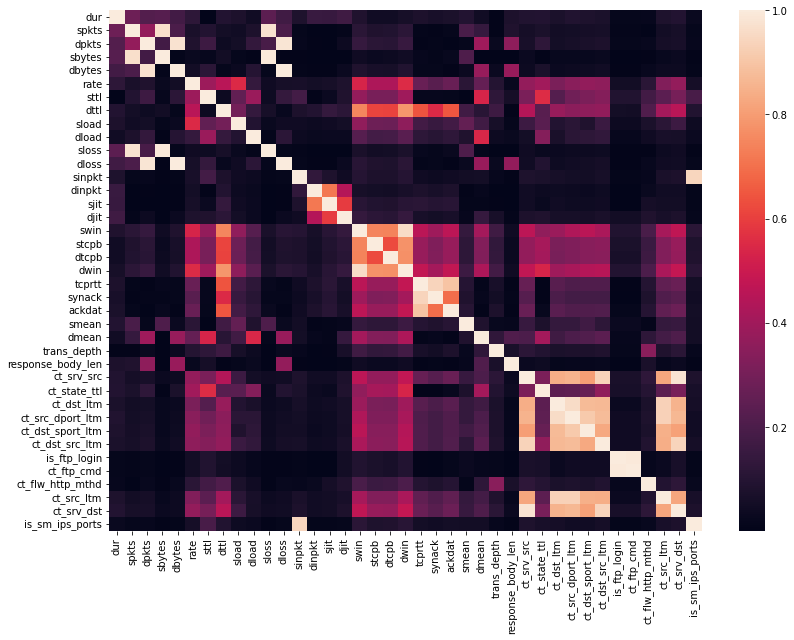

In [5]:
# correlation heatmap
corr = train_X1.corr().abs()

plt.figure(figsize=(12, 9))
sns.heatmap(corr)
plt.tight_layout()
plt.show()

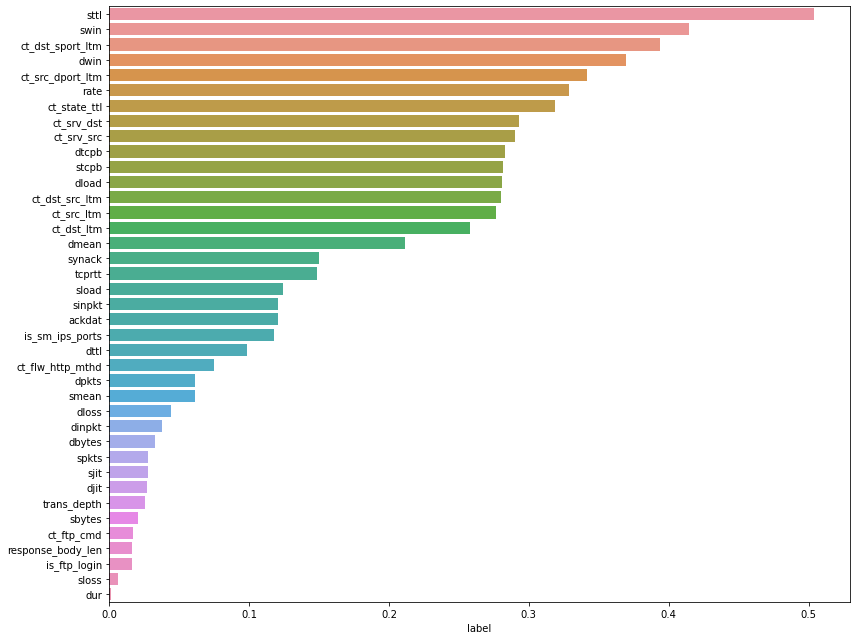

In [6]:
# correlation rankings between features and label
train_X2 = train_X1.copy()
train_X2['label'] = train_Y

corr2 = train_X2.corr().abs()

plt.figure(figsize=(12, 9))
sns.barplot(x=corr2['label'].iloc[:-1], y=corr2.columns[:-1], order=corr2['label'].iloc[:-1].sort_values(ascending=False).index)
plt.tight_layout()
plt.show()

In [7]:
# consider redundant if correlation > threshold
threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > threshold:
            redundant.append((i, j))
display(redundant)

[('spkts', 'sbytes'),
 ('dpkts', 'dbytes'),
 ('spkts', 'sloss'),
 ('sbytes', 'sloss'),
 ('dpkts', 'dloss'),
 ('dbytes', 'dloss'),
 ('swin', 'dwin'),
 ('tcprtt', 'synack'),
 ('tcprtt', 'ackdat'),
 ('ct_srv_src', 'ct_dst_ltm'),
 ('ct_srv_src', 'ct_src_dport_ltm'),
 ('ct_dst_ltm', 'ct_src_dport_ltm'),
 ('ct_srv_src', 'ct_dst_sport_ltm'),
 ('ct_dst_ltm', 'ct_dst_sport_ltm'),
 ('ct_src_dport_ltm', 'ct_dst_sport_ltm'),
 ('ct_srv_src', 'ct_dst_src_ltm'),
 ('ct_dst_ltm', 'ct_dst_src_ltm'),
 ('ct_src_dport_ltm', 'ct_dst_src_ltm'),
 ('ct_dst_sport_ltm', 'ct_dst_src_ltm'),
 ('is_ftp_login', 'ct_ftp_cmd'),
 ('ct_srv_src', 'ct_src_ltm'),
 ('ct_dst_ltm', 'ct_src_ltm'),
 ('ct_src_dport_ltm', 'ct_src_ltm'),
 ('ct_dst_sport_ltm', 'ct_src_ltm'),
 ('ct_dst_src_ltm', 'ct_src_ltm'),
 ('ct_srv_src', 'ct_srv_dst'),
 ('ct_dst_ltm', 'ct_srv_dst'),
 ('ct_src_dport_ltm', 'ct_srv_dst'),
 ('ct_dst_sport_ltm', 'ct_srv_dst'),
 ('ct_dst_src_ltm', 'ct_srv_dst'),
 ('ct_src_ltm', 'ct_srv_dst'),
 ('sinpkt', 'is_sm_ips_po

In [8]:
# select redundant columns to drop
corr3 = corr2['label'].iloc[:-1].copy()
drop = []

for i, j in redundant:
    if corr3[i] > corr3[j] and j not in drop:
        drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'tcprtt', 'ackdat', 'ct_dst_ltm', 'ct_srv_src', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


In [9]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, SequentialFeatureSelector, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [10]:
# select 1 best feature iteratively with chi2, ANOVA, mutual info

subset_all = []
for sf in [chi2, f_classif, mutual_info_classif]:
    cols = []
    selector = SelectKBest(sf, k=1)
    for k in trange(train_X1.shape[1]):
        # select one best feature and add it to subset
        selector.fit(train_X1.drop(cols, axis=1), train_Y)
        f = selector.get_feature_names_out(train_X1.columns.drop(cols))
        cols.append(f[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 39/39 [00:00<00:00, 47.35it/s]


['swin', 'dwin', 'sttl', 'ct_dst_sport_ltm', 'ct_src_dport_ltm', 'dload', 'dtcpb', 'stcpb', 'rate', 'ct_dst_src_ltm', 'ct_srv_dst', 'ct_srv_src', 'ct_src_ltm', 'ct_dst_ltm', 'dmean', 'ct_state_ttl', 'is_sm_ips_ports', 'sinpkt', 'dttl', 'sload', 'tcprtt', 'synack', 'ct_flw_http_mthd', 'smean', 'ackdat', 'dinpkt', 'dpkts', 'sjit', 'dloss', 'ct_ftp_cmd', 'is_ftp_login', 'dbytes', 'sbytes', 'spkts', 'response_body_len', 'djit', 'trans_depth', 'sloss', 'dur']


100%|██████████| 39/39 [00:01<00:00, 38.81it/s]


['sttl', 'swin', 'ct_dst_sport_ltm', 'dwin', 'ct_src_dport_ltm', 'rate', 'ct_state_ttl', 'ct_srv_dst', 'ct_srv_src', 'dtcpb', 'stcpb', 'dload', 'ct_dst_src_ltm', 'ct_src_ltm', 'ct_dst_ltm', 'dmean', 'synack', 'tcprtt', 'sload', 'sinpkt', 'ackdat', 'is_sm_ips_ports', 'dttl', 'ct_flw_http_mthd', 'dpkts', 'smean', 'dloss', 'dinpkt', 'dbytes', 'spkts', 'sjit', 'djit', 'trans_depth', 'sbytes', 'ct_ftp_cmd', 'response_body_len', 'is_ftp_login', 'sloss', 'dur']


100%|██████████| 39/39 [04:55<00:00,  7.57s/it]

['sbytes', 'smean', 'sload', 'dbytes', 'ct_state_ttl', 'rate', 'dur', 'dmean', 'dttl', 'dinpkt', 'sttl', 'dload', 'dpkts', 'synack', 'tcprtt', 'sinpkt', 'ct_dst_sport_ltm', 'ackdat', 'sjit', 'spkts', 'djit', 'ct_src_dport_ltm', 'dloss', 'ct_srv_dst', 'sloss', 'ct_srv_src', 'swin', 'stcpb', 'dtcpb', 'dwin', 'ct_dst_src_ltm', 'ct_dst_ltm', 'ct_src_ltm', 'response_body_len', 'is_sm_ips_ports', 'ct_flw_http_mthd', 'is_ftp_login', 'trans_depth', 'ct_ftp_cmd']


In [11]:
# select 1 best feature iteratively with SFS, using RF, LR
for model in [RandomForestClassifier(random_state=0, n_jobs=-1), LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)]:
    cols = []
    selector = SequentialFeatureSelector(model, n_features_to_select=1, scoring='f1', cv=5, n_jobs=-1)
    for k in trange(train_X1.shape[1]-1):
        selector.fit(train_X1.drop(cols, axis=1), train_Y)
        f = train_X1.columns.drop(cols)[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)
print(len(subset_all))

100%|██████████| 38/38 [22:12<00:00, 35.06s/it]


['sbytes', 'sttl', 'smean', 'dbytes', 'ct_state_ttl', 'dmean', 'synack', 'tcprtt', 'dur', 'dpkts', 'dload', 'rate', 'ackdat', 'dttl', 'sinpkt', 'dinpkt', 'sload', 'djit', 'sjit', 'spkts', 'sloss', 'dloss', 'response_body_len', 'is_sm_ips_ports', 'swin', 'is_ftp_login', 'ct_ftp_cmd', 'dtcpb', 'stcpb', 'dwin', 'ct_dst_sport_ltm', 'ct_flw_http_mthd', 'trans_depth', 'ct_srv_dst', 'ct_srv_src', 'ct_dst_src_ltm', 'ct_src_dport_ltm', 'ct_src_ltm', 'ct_dst_ltm']


100%|██████████| 38/38 [00:56<00:00,  1.47s/it]

['sttl', 'dload', 'ct_state_ttl', 'rate', 'dmean', 'sinpkt', 'is_sm_ips_ports', 'dloss', 'dpkts', 'swin', 'response_body_len', 'sbytes', 'sload', 'sloss', 'trans_depth', 'dinpkt', 'djit', 'dbytes', 'spkts', 'ct_ftp_cmd', 'dur', 'sjit', 'is_ftp_login', 'dtcpb', 'smean', 'stcpb', 'synack', 'dwin', 'tcprtt', 'ct_dst_sport_ltm', 'ct_flw_http_mthd', 'ackdat', 'dttl', 'ct_src_dport_ltm', 'ct_srv_src', 'ct_srv_dst', 'ct_src_ltm', 'ct_dst_ltm', 'ct_dst_src_ltm']
5


In [12]:
# select 1 best feature iteratively with importance, using RF, LR
for model in [RandomForestClassifier(random_state=0, n_jobs=-1), LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)]:
    cols = []
    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    for k in trange(train_X1.shape[1]-1):
        selector.fit(train_X1.drop(cols, axis=1), train_Y)
        f = train_X1.columns.drop(cols)[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


['ct_dst_src_ltm', 'sttl', 'ct_state_ttl', 'sload', 'smean', 'sbytes', 'rate', 'ct_dst_sport_ltm', 'ct_srv_dst', 'dbytes', 'dttl', 'dmean', 'dload', 'dur', 'dpkts', 'ct_srv_src', 'synack', 'sinpkt', 'tcprtt', 'ackdat', 'dinpkt', 'sjit', 'djit', 'spkts', 'stcpb', 'dtcpb', 'sloss', 'dloss', 'ct_dst_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'ct_src_ltm', 'response_body_len', 'is_sm_ips_ports', 'ct_flw_http_mthd', 'trans_depth', 'is_ftp_login', 'ct_ftp_cmd']


100%|██████████| 38/38 [03:06<00:00,  4.91s/it]

['ct_dst_sport_ltm', 'dload', 'tcprtt', 'synack', 'ackdat', 'ct_src_dport_ltm', 'swin', 'sload', 'ct_dst_src_ltm', 'dmean', 'djit', 'trans_depth', 'dloss', 'dpkts', 'dbytes', 'spkts', 'sinpkt', 'sloss', 'sbytes', 'is_sm_ips_ports', 'rate', 'dwin', 'ct_src_ltm', 'ct_dst_ltm', 'ct_srv_dst', 'ct_srv_src', 'dinpkt', 'sttl', 'ct_state_ttl', 'ct_flw_http_mthd', 'dtcpb', 'stcpb', 'response_body_len', 'ct_ftp_cmd', 'sjit', 'smean', 'is_ftp_login', 'dttl', 'dur']


In [13]:
# save selected feature sets to csv file
pd.DataFrame(subset_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/Feature_sets.csv')

In [14]:
# measure performance by cv(f1 score)
cv_times_all = []
f1_all = []
model = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
for i in range(len(subset_all)):
    cv_times = []
    f1s = []
    for k in trange(train_X1.shape[1]):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][:k+1]], train_Y, scoring='f1', n_jobs=-1)
        second2 = time.time()
        cv_times.append(second2 - second)
        f1s.append((cv.mean(), cv.std()))
    
    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


In [15]:
pd.DataFrame(cv_times_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/Time_LR.csv')
pd.DataFrame(f1_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/F1_LR.csv')

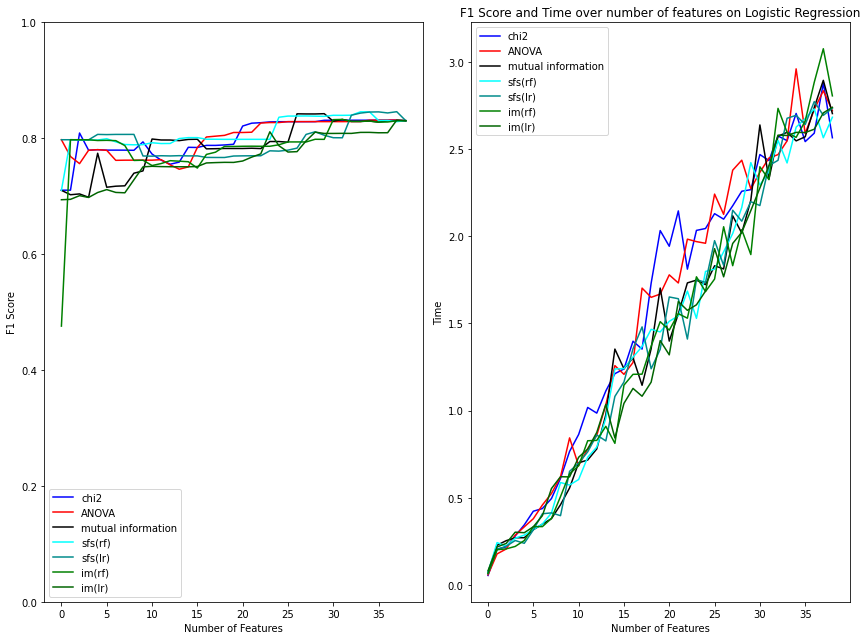

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Logistic Regression', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[3,:,0], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[4,:,0], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[5,:,0], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[6,:,0], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), cv_times_all[3], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[4], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), cv_times_all[5], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[6], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.tight_layout()
plt.show()

In [17]:
cv_times_all = []
f1_all = []

model = GradientBoostingClassifier(random_state=0)
for i in range(len(subset_all)):
    cv_times = []
    f1s = []
    for k in trange(train_X1.shape[1]):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][:k+1]], train_Y, scoring='f1', n_jobs=-1)
        second2 = time.time()
        cv_times.append(second2 - second)
        f1s.append((cv.mean(), cv.std()))
    
    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 39/39 [08:12<00:00, 12.62s/it]


In [18]:
pd.DataFrame(cv_times_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/Time_GB.csv')
pd.DataFrame(f1_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/F1_GB.csv')

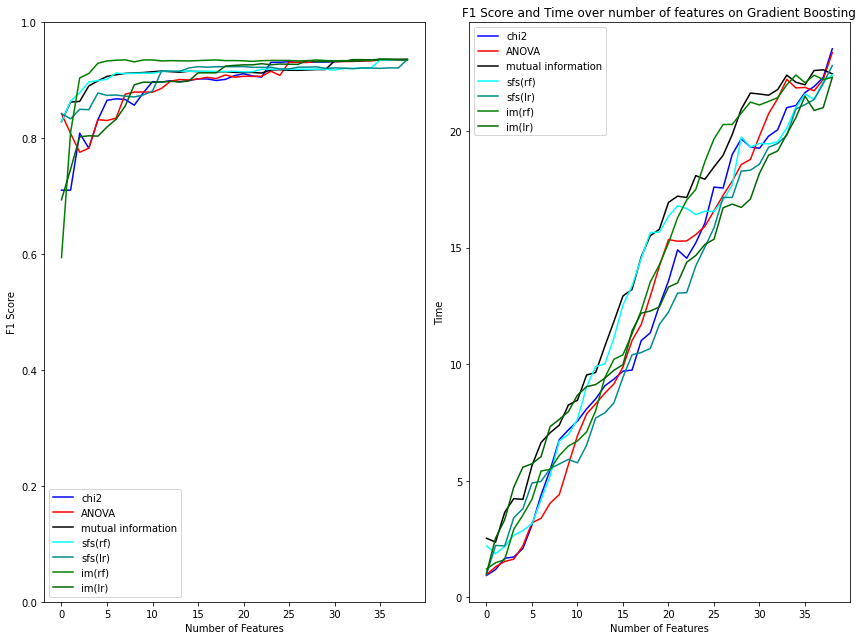

In [19]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Gradient Boosting', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[3,:,0], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[4,:,0], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[5,:,0], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[6,:,0], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), cv_times_all[3], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[4], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), cv_times_all[5], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[6], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.tight_layout()
plt.show()

In [20]:
from keras import Sequential, layers, optimizers, losses, metrics, callbacks
from sklearn.model_selection import StratifiedKFold

In [21]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [22]:
cv_times_all = []
f1_all = []

kf = StratifiedKFold(shuffle=True, random_state=0)
callback = callbacks.EarlyStopping(patience=3, min_delta=0.1, restore_best_weights=True)
for i in range(len(subset_all)):
    cv_times = []
    f1s = []
    for k in trange(train_X1.shape[1]):
        model = ModelCreate((k+1,))
        # cross validation
        j = 0
        cv_time = 0
        cv = np.zeros(shape=5)
        train_X2 = train_X1[subset_all[i][:k+1]].copy()
        for train_index, test_index in kf.split(train_X2, train_Y):
            x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
            y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

            second = time.time()
            model.fit(x_train_fold.values, y_train_fold.values, validation_data=(x_test_fold, y_test_fold), epochs=30, callbacks=[callback], use_multiprocessing=True, verbose=0)
            predict = model.predict(x_test_fold, use_multiprocessing=True)
            predict = np.where(predict < 0.5, 0, 1)
            cv[j] = f1_score(y_test_fold, predict)
            second2 = time.time()
            cv_time += second2 - second
            j += 1
        cv_times.append(cv_time)
        f1s.append((cv.mean(), cv.std()))
    
    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 39/39 [2:00:47<00:00, 185.83s/it]


In [23]:
pd.DataFrame(cv_times_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/Time_DNN.csv')
pd.DataFrame(f1_all, index=['chi2', 'ANOVA', 'mutualinfo', 'sfs(rf)', 'sfs(lr)', 'im(rf)', 'im(lr)']).to_csv('../Results/F1_DNN.csv')

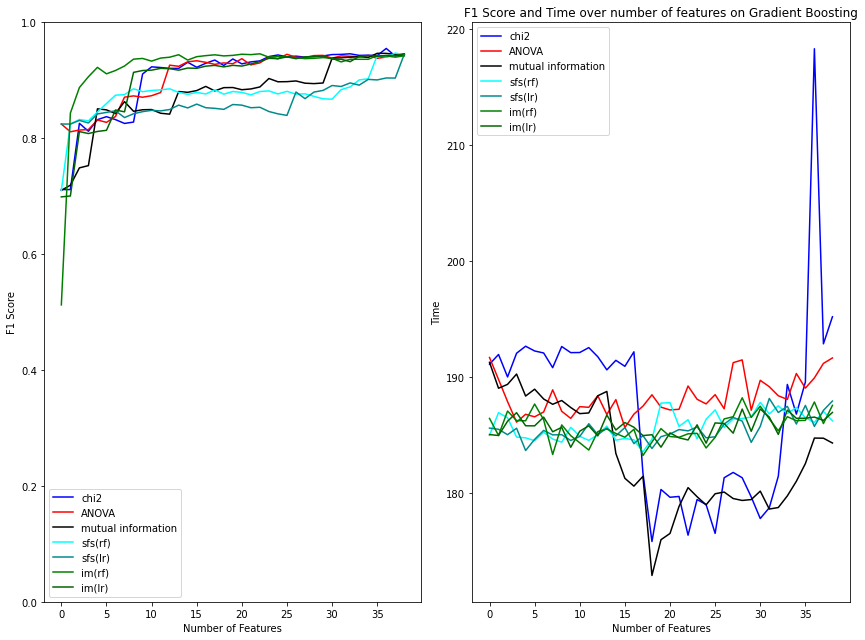

In [24]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Gradient Boosting', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[3,:,0], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[4,:,0], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[5,:,0], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[6,:,0], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='chi2')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='ANOVA')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='mutual information')
plt.plot(range(train_X1.shape[1]), cv_times_all[3], color='cyan', linestyle='-', label='sfs(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[4], color='darkcyan', linestyle='-', label='sfs(lr)')
plt.plot(range(train_X1.shape[1]), cv_times_all[5], color='green', linestyle='-', label='im(rf)')
plt.plot(range(train_X1.shape[1]), cv_times_all[6], color='darkgreen', linestyle='-', label='im(lr)')

plt.legend()

plt.tight_layout()
plt.show()